In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

# модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# стандартизация
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# кодирование признаков
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# понижение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ds = pd.read_csv('data/ds_salaries.csv')
df_ds.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Информация о данных

`work_year` [categorical] : Это конкретный год, в котором была выплачена заработная плата. В разные годы могут быть разные экономические условия, которые могут повлиять на уровень заработной платы.

`experience_level` [categorical] : уровень опыта, который человек имеет на конкретной работе. Это является ключевым фактором при расчете заработной платы, поскольку, как правило, более опытные сотрудники получают более высокую зарплату благодаря своим передовым навыкам и знаниям.

`employment_type` [categorical] : Характер трудового договора, например, полный рабочий день, неполный рабочий день или по контракту, может существенно влиять на заработную плату. Сотрудники, работающие полный рабочий день, часто получают более высокую годовую заработную плату по сравнению со своими коллегами, работающими неполный рабочий день или по контракту.

`job_title` [categorical] : Должность, которую человек занимает в компании. Разные должности имеют разную шкалу заработной платы в зависимости от требуемых обязанностей и навыков. Например, на руководящих должностях обычно платят больше, чем на должностях начального уровня.

`salary` [numerical] : общая сумма заработной платы, выплачиваемой сотруднику. На это напрямую влияют такие факторы, как уровень опыта, название должности и тип занятости.

`salary_currency` [categorical] : Конкретная валюта, в которой выплачивается заработная плата, обозначаемая кодом ISO 4217. Обменные курсы могут влиять на величину заработной платы при пересчете в разные валюты.

`salaryinusd` [numerical] :  общая сумма заработной платы брутто, пересчитанная в доллары США. Это позволяет проводить единообразное сравнение заработной платы в разных странах и валютах.


`employee_residence` [categorical]: Основная страна проживания сотрудника, обозначаемая кодом ISO 3166. Стоимость жизни и преобладающие ставки заработной платы в стране проживания сотрудника могут влиять на уровень заработной платы.

`remote_ratio` [ratio]: доля работы, выполняемой удаленно. С ростом удаленной работы компании могут корректировать заработную плату в зависимости от стоимости жизни в месте нахождения сотрудника и доли удаленной работы.

`company_location` [categorical]: местоположение главного офиса работодателя или филиала, с которым заключен контракт. Компании в разных регионах могут предлагать разные уровни заработной платы из-за различных экономических условий и стоимости жизни.

`company_size` [categorical]:  Среднее число сотрудников в компании в течение рабочего года. Крупные компании часто имеют структурированную шкалу заработной платы и могут предлагать более высокие оклады за счет эффекта масштаба и увеличения доходов.


### . Первичный анализ данных:
* Импортировать данные из файла ds_salaries.csv.
* Очистить данные от дубликатов и пропущенных значений.
* Исследовать типы данных, описательную статистику и корреляции между признаками.
* Визуализировать данные с помощью Matplotlib и Seaborn.

In [3]:
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [4]:
df_ds.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
# пропусков нет

In [6]:
df_ds.duplicated().sum()

1171

In [7]:
# Дубликаты 1171 наблюдений. Будем считать, что это ошибки при вводе, которые повлекли дублирование данных.

In [8]:
# Удалим дубликаты
df_ds = df_ds.drop_duplicates()

In [9]:
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


In [10]:
# experience_level [categorical] : уровень опыта
# Применим mappin чем выше опыт, тем выше рейтинг (от 1 до 4). Т.к опыт влияет на уровень зп

In [11]:
df_ds['experience_level'].value_counts()

experience_level
SE    1554
MI     664
EN     270
EX      96
Name: count, dtype: int64

EN (Entry Level) - начальный уровень опыта работы. Это может быть для людей, только начинающих свою карьеру или имеющих минимальный опыт работы в данной области.

EX (Executive Level) - высокий уровень опыта работы. Это обусловлено тем, что в данном случае количество участников с уровнем опыта EX значительно меньше, что указывает на более высокий и специализированный уровень работы.

In [12]:
solary_map = {
             'EN': 1,
             'MI': 2,
             'SE': 3,
             'EX': 4,
}

df_ds['experience_level'] = df_ds['experience_level'].map(solary_map).astype('int8')

In [13]:
df_ds['experience_level'].value_counts()

experience_level
3    1554
2     664
1     270
4      96
Name: count, dtype: int64

In [14]:
# employment_type [categorical]:
# Сотрудники, работающие полный рабочий день, часто получают более высокую годовую заработную плату
# по сравнению со своими коллегами, работающими неполный рабочий день или по контракту
# рейтинг (от 1 до 4)

In [15]:
df_ds['employment_type'].value_counts()

employment_type
FT    2547
PT      17
CT      10
FL      10
Name: count, dtype: int64

In [16]:
employment_map = {
             'FT': 4,
             'PT': 1,
             'CT': 3,
             'FL': 2,
}

df_ds['employment_type'] = df_ds['employment_type'].map(employment_map).astype('int8')

In [17]:
df_ds['employment_type'].value_counts()

employment_type
4    2547
1      17
3      10
2      10
Name: count, dtype: int64

In [18]:
# company_size [categorical]: 
# Среднее число сотрудников в компании в течение рабочего года. 
# Крупные компании часто имеют структурированную шкалу заработной платы и могут предлагать более высокие оклады за счет эффекта масштаба и увеличения доходов.
# S (Small) - Малые компании:
# M (Medium) - Средние компании:
# L (Large) - Крупные компании:

In [19]:
company_map = {
             'L': 3,
             'M': 2,
             'S': 1
}

df_ds['company_size'] = df_ds['company_size'].map(company_map).astype('int8')

In [20]:
# удалим признаки 'salary', 'salary_currency', 'employee_residence', 'company_location'
df_ds = df_ds.drop(['salary', 'salary_currency', 'employee_residence', 'company_location'], axis=1)

In [21]:
# Обобщим професси по близости
job_categories = {
    'Data Scientist': ['Data Scientist', 'Applied Data Scientist', 'Data Scientist Lead', 'Data Science Consultant'],
    'Machine Learning Engineer': ['Machine Learning Software Engineer', 'Deep Learning Engineer', 'ML Engineer', 'Machine Learning Researcher', 'Lead Machine Learning Engineer', 'Machine Learning Engineer', 'Machine Learning Scientist', 'Machine Learning Infrastructure Engineer'],
    'Data Analyst': ['Data Analyst', 'Business Data Analyst', 'Marketing Data Analyst'],
    'Data Engineer': ['Data Engineer', 'Big Data Engineer', 'Lead Data Engineer'],
    'Research Scientist': ['Research Scientist', 'ML Researcher', 'Deep Learning Researcher'],
    'Manager': ['Lead Data Scientist', 'Data Lead', 'Head of Data Science', 'Data Manager', 'Data Analytics Manager', 'Head of Data', 'Machine Learning Manager', 'Principal Data Scientist', 'Data Science Manager', 'Director of Data Science', 'Data Science Lead'],
    'Engineer': ['Software Data Engineer', 'Data DevOps Engineer', 'Cloud Database Engineer'],
    'AI Specialist': ['AI Developer', 'AI Scientist', 'AI Programmer'],
    'Architect': ['Data Architect', 'Big Data Architect', 'Cloud Data Architect']
}

# Создаем новый столбец `job_category`
df_ds['job_category'] = 'Other'  # Значение по умолчанию для тех профессий, которые не попали в список

for category, titles in job_categories.items():
    df_ds.loc[df_ds['job_title'].isin(titles), 'job_category'] = category

In [22]:
df_ds['job_category'].value_counts()

job_category
Data Engineer                615
Data Scientist               573
Data Analyst                 413
Other                        359
Machine Learning Engineer    301
Manager                      153
Architect                     67
Research Scientist            66
AI Specialist                 29
Engineer                       8
Name: count, dtype: int64

In [23]:
# применим get_dummes к столбцам 'remote_ratio', 'job_category'
for cat_colname in df_ds[['remote_ratio', 'job_category']]:
    df_ds = pd.concat([df_ds, pd.get_dummies(df_ds[cat_colname], prefix=cat_colname)], axis=1)

In [24]:
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   work_year                               2584 non-null   int64 
 1   experience_level                        2584 non-null   int8  
 2   employment_type                         2584 non-null   int8  
 3   job_title                               2584 non-null   object
 4   salary_in_usd                           2584 non-null   int64 
 5   remote_ratio                            2584 non-null   int64 
 6   company_size                            2584 non-null   int8  
 7   job_category                            2584 non-null   object
 8   remote_ratio_0                          2584 non-null   bool  
 9   remote_ratio_50                         2584 non-null   bool  
 10  remote_ratio_100                        2584 non-null   bool  
 11  job_categ

In [25]:
df_ds.drop(['job_title', 'job_category', 'work_year', 'remote_ratio'], axis=1, inplace=True)

In [26]:
df_ds.head()

,experience_level,employment_type,salary_in_usd,company_size,remote_ratio_0,remote_ratio_50,remote_ratio_100,job_category_AI Specialist,job_category_Architect,job_category_Data Analyst,job_category_Data Engineer,job_category_Data Scientist,job_category_Engineer,job_category_Machine Learning Engineer,job_category_Manager,job_category_Other,job_category_Research Scientist
0,3,4,85847,3,False,False,True,False,False,False,False,False,False,False,True,False,False
1,2,3,30000,1,False,False,True,False,False,False,False,False,False,True,False,False,False
2,2,3,25500,1,False,False,True,False,False,False,False,False,False,True,False,False,False
3,3,4,175000,2,False,False,True,False,False,False,False,True,False,False,False,False,False
4,3,4,120000,2,False,False,True,False,False,False,False,True,False,False,False,False,False


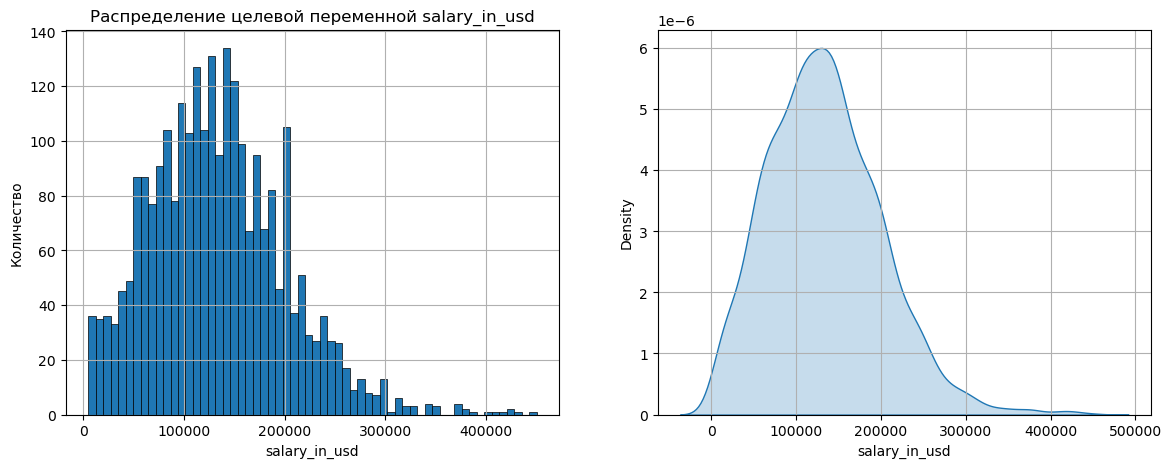

В целом нормальное распределение


In [27]:
plt.figure(figsize=(14,5))
plt.subplot(121)
df_ds['salary_in_usd'].hist(density=False, bins=60, linewidth=0.5, edgecolor='k')
plt.title('Распределение целевой переменной salary_in_usd')
plt.ylabel('Количество')
plt.xlabel('salary_in_usd')
# plt.grid(False)
plt.subplot(122)
sns.kdeplot(df_ds['salary_in_usd'], shade=True, legend=False)
plt.xlabel('salary_in_usd')
plt.grid()

plt.show()
print('В целом нормальное распределение')

In [28]:
#Построим матрицу корреляции для выявления линейной зависимоти

In [29]:
# подготовим признаки
df_corr = df_ds

In [30]:
corr_matrix = df_corr.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

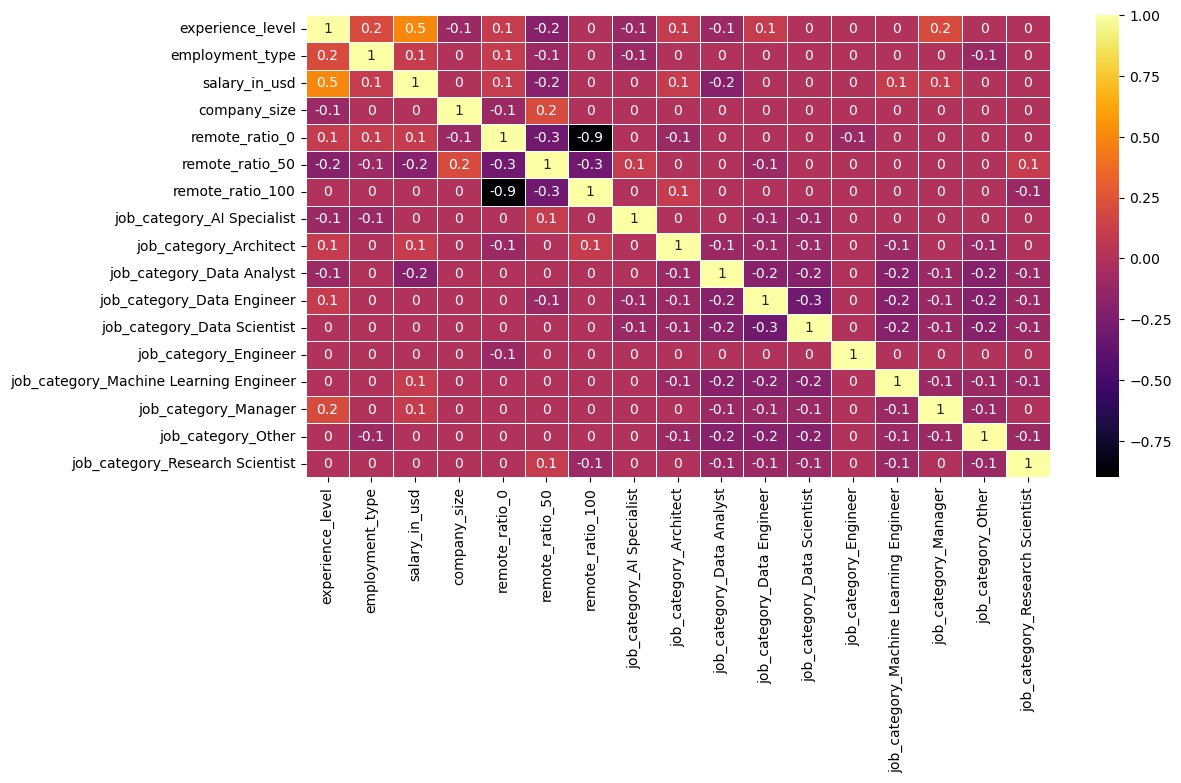

In [31]:
plt.figure(figsize=(12, 6))

sns.heatmap(corr_matrix, annot=True, linewidths=0.7, cmap='inferno')
plt.xticks(rotation=90)
#plt.yticks(rotation=35)
plt.show()

In [32]:
# experience_level сильная корреляция с целевой переменной 0,5

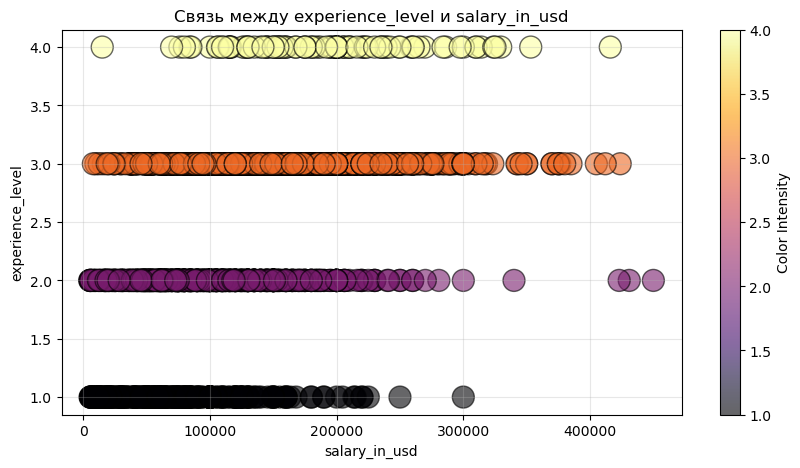

Чем больше experience_level, тем выше salary_in_usd


In [33]:
# Построение графика рассеивания
plt.figure(figsize=(10,5))
plt.scatter(data=df_ds, x=df_ds['salary_in_usd'], c=df_ds['experience_level'], y='experience_level',alpha=0.6, linewidths=1, s=250, edgecolors='k', cmap='inferno')

plt.title('Связь между experience_level и salary_in_usd')
plt.xlabel('salary_in_usd')
plt.ylabel('experience_level')
plt.colorbar(label='Color Intensity')
plt.grid(alpha=0.3)

plt.show()
print('Чем больше experience_level, тем выше salary_in_usd')

In [56]:
### сохраним датасет
df_ds.to_csv('data/ds_salaries_clean.csv', index=False, encoding='utf8')

### 2. Построение модели линейной регрессии:
* Разделить данные на обучающую и тестовую выборки.
* Построить модель линейной регрессии для прогнозирования заработной платы.
* Оценить качество модели с помощью метрик MAE, MSE и R-квадрат.
* Проанализировать значимость признаков и мультиколлинеарность.

In [34]:
scaled_features = StandardScaler().fit_transform(df_ds)
select_features = pd.DataFrame(scaled_features, columns=df_ds.columns)

select_features.head()

,experience_level,employment_type,salary_in_usd,company_size,remote_ratio_0,remote_ratio_50,remote_ratio_100,job_category_AI Specialist,job_category_Architect,job_category_Data Analyst,job_category_Data Engineer,job_category_Data Scientist,job_category_Engineer,job_category_Machine Learning Engineer,job_category_Manager,job_category_Other,job_category_Research Scientist
0,0.589988,0.112544,-0.708575,1.985225,-0.921062,-0.27931,1.064788,-0.106538,-0.163153,-0.436159,-0.558875,-0.533791,-0.055728,-0.363103,3.986087,-0.401682,-0.161899
1,-0.785941,-3.477761,-1.540574,-2.433225,-0.921062,-0.27931,1.064788,-0.106538,-0.163153,-0.436159,-0.558875,-0.533791,-0.055728,2.754037,-0.250873,-0.401682,-0.161899
2,-0.785941,-3.477761,-1.607615,-2.433225,-0.921062,-0.27931,1.064788,-0.106538,-0.163153,-0.436159,-0.558875,-0.533791,-0.055728,2.754037,-0.250873,-0.401682,-0.161899
3,0.589988,0.112544,0.619612,-0.224000,-0.921062,-0.27931,1.064788,-0.106538,-0.163153,-0.436159,-0.558875,1.873392,-0.055728,-0.363103,-0.250873,-0.401682,-0.161899
4,0.589988,0.112544,-0.199769,-0.224000,-0.921062,-0.27931,1.064788,-0.106538,-0.163153,-0.436159,-0.558875,1.873392,-0.055728,-0.363103,-0.250873,-0.401682,-0.161899


In [35]:
X = select_features.drop(['salary_in_usd'], axis=1)
Y = select_features['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)

print('TRAIN')
print(f'MSE: {mean_squared_error(y_train_pred, y_train)}')
print(f'MAE: {mean_absolute_error(y_train_pred, y_train)}')
print(f'R2: {r2_score(y_train, y_train_pred)}')

TRAIN
MSE: 0.7253844206905352
MAE: 0.654463270899577
R2: 0.2798534707365


In [37]:
y_train_pred = lr.predict(X_test)

print('TEST')
print(f'MSE: {mean_squared_error(y_train_pred, y_test)}')
print(f'MAE: {mean_absolute_error(y_train_pred, y_test)}')
print(f'R2: {r2_score(y_test, y_train_pred)}')

TEST
MSE: 0.7079196721599711
MAE: 0.6548350776978195
R2: 0.270791504662382


In [38]:
# На линейной регрессии качество модели невысокое, возможно недостаточно данных, посмотрим какие результы будет на более сложных моделях

### 3. Построение модели дерева решений:
* Построить модель дерева решений для прогнозирования заработной платы.
* Оценить качество модели с помощью метрик RMSE и R-квадрат.
* Подберите гиперпараметры для модели дерево решений
* Визуализировать дерево решений.

In [39]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [40]:
# Прогноз и оценка качества модели
y_tree_pred = tree_model.predict(X_test)
rmse = mean_squared_error(y_test, y_tree_pred, squared=False)
r2_tree = r2_score(y_test, y_tree_pred)

print(f'RMSE: {rmse}, R²: {r2_tree}')

RMSE: 0.8780033864932807, R²: 0.2059275646568577


In [41]:
%%time

# Подбор гиперпараметров для улучшения результатов модели GradientBoostingRegressor

params = {'min_samples_split': [50, 100, 200, 400],
          'max_depth': [3, 5, 7, 10]}

gs_tree_model = GridSearchCV(tree_model, 
                  params,
                  scoring='r2',
                  cv=KFold(n_splits=5, # колич. разбиений/итераций в кросс-валидации
                           random_state=42,
                           shuffle=True),
                  n_jobs=-1
                 )

gs_tree_model.fit(X_train, y_train)

/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9

CPU times: user 839 ms, sys: 318 ms, total: 1.16 s
Wall time: 2.23 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_split': [50, 100, 200, 400]},
             scoring='r2')

In [42]:
gs_tree_model.best_params_

{'max_depth': 10, 'min_samples_split': 100}

In [43]:
gs_tree_model.best_score_

0.27761166407522564

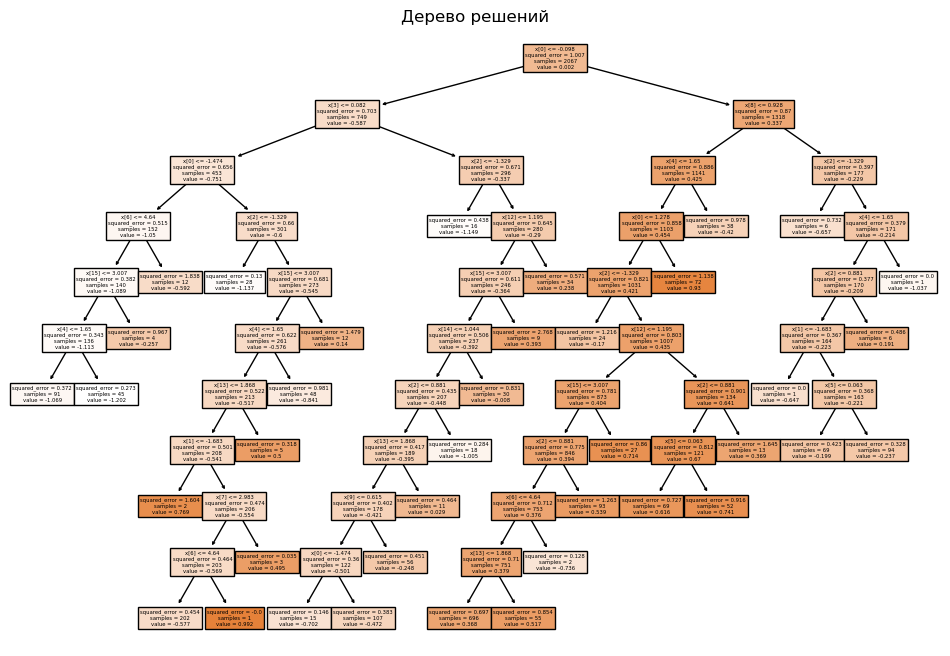

In [44]:
# Визуализация дерева
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(gs_tree_model.best_estimator_, filled=True)
plt.title("Дерево решений")
plt.show()

### 4. Построение ансамблевой модели:
* Построить ансамблевую модель, используя Random Forest и Boosting.
* Сравнить качество ансамблевой модели с отдельными моделями.
* Оценить важность признаков в ансамблевой модели.

In [45]:
%%time
model_rand = RandomForestRegressor(random_state=42, max_depth=7, n_estimators=50)
model_rand.fit(X_train, y_train)

print(f'r2_score_trian: {model_rand.score(X_train, y_train)}')
print(f'r2_score_test: {model_rand.score(X_test, y_test)}')

r2_score_trian: 0.37141961423021674
r2_score_test: 0.2624846528700455
CPU times: user 168 ms, sys: 2.09 ms, total: 170 ms
Wall time: 168 ms


In [46]:
%%time

# Подбор гиперпараметров для улучшения результатов модели RandomForestRegressor

params = {'n_estimators': [50, 100, 200, 400],
          'max_depth': [3, 5, 7, 10]}

gs_rand = GridSearchCV(model_rand, 
                  params,
                  scoring='r2',
                  cv=KFold(n_splits=5, # колич. разбиений/итераций в кросс-валидации
                           random_state=42,
                           shuffle=True),
                  n_jobs=-1
                 )

gs_rand.fit(X_train, y_train)

CPU times: user 477 ms, sys: 14.7 ms, total: 492 ms
Wall time: 4.23 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(max_depth=7, n_estimators=50,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [47]:
gs_rand.best_params_

{'max_depth': 7, 'n_estimators': 100}

In [48]:
gs_rand.best_score_

0.2829547496155239

In [49]:
%%time
model_g_boost = GradientBoostingRegressor(random_state=42, max_depth=10, n_estimators=100)
model_g_boost.fit(X_train, y_train)

print(f'r2_score_trian: {model_g_boost.score(X_train, y_train)}')
print(f'r2_score_test: {model_g_boost.score(X_test, y_test)}')

r2_score_trian: 0.4176672043684001
r2_score_test: 0.22168105899412527
CPU times: user 346 ms, sys: 2.95 ms, total: 349 ms
Wall time: 346 ms


In [50]:
%%time

# Подбор гиперпараметров для улучшения результатов модели GradientBoostingRegressor

params = {'n_estimators': [50, 100, 200, 400],
          'max_depth': [3, 5, 7, 10]}

gs_g_boost = GridSearchCV(model_g_boost, 
                  params,
                  scoring='r2',
                  cv=KFold(n_splits=5, # колич. разбиений/итераций в кросс-валидации
                           random_state=42,
                           shuffle=True),
                  n_jobs=-1
                 )

gs_g_boost.fit(X_train, y_train)

CPU times: user 282 ms, sys: 19.3 ms, total: 302 ms
Wall time: 3.04 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [51]:
gs_g_boost.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [52]:
gs_g_boost.best_score_

0.27944110355449103

In [53]:
print('Важность признаков для модели GradientBoostingRegressor')
feature_importances = pd.DataFrame(zip(model_g_boost.feature_names_in_, model_g_boost.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

Важность признаков для модели GradientBoostingRegressor


,feature_name,importance
0,experience_level,0.526440
2,company_size,0.102385
8,job_category_Data Analyst,0.083056
3,remote_ratio_0,0.046534
4,remote_ratio_50,0.041162
6,job_category_AI Specialist,0.031293
12,job_category_Machine Learning Engineer,0.028236
1,employment_type,0.025915
15,job_category_Research Scientist,0.022839
14,job_category_Other,0.022411


In [55]:
# На ансамблевых моделяъ качество модели также довольно низкое
# на данном этапе будем считать что данных недостаточно

### 5. Понижение размерности:
* Применить Principal Component Analysis (PCA) для снижения размерности данных.
* Построить модель линейной регрессии с использованием данных, полученных после PCA.
* Сравнить качество модели с использованием исходных данных.

In [69]:
pca = PCA(n_components=0.95, random_state=42)
pca_result = pca.fit_transform(X)

In [70]:
# Модель линейной регрессии с использованием PCA
X_train_pca, X_test_pca = train_test_split(pca_result, test_size=0.2, random_state=42)
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

LinearRegression()

In [71]:
y_pca_pred = model_pca.predict(X_test_pca)
pca_mae = mean_absolute_error(y_test, y_pca_pred)
pca_mse = mean_squared_error(y_test, y_pca_pred)
pca_r2 = r2_score(y_test, y_pca_pred)

print(f'PCA MAE: {pca_mae}') 
print(f'PCA MSE: {pca_mse}') 
print(f'PCA R²: {pca_r2}')

PCA MAE: 0.6774188715533223
PCA MSE: 0.7404290227665501
PCA R²: 0.23730452079612552


In [72]:
### Понижение размерности PCA положительно не повлияло на метрики MAE и MSE R2, даже напротив ухудшело их. Скорее всего недостаточно данных.

### 7. Кластеризация:
* Применить метод K-Means для кластеризации данных по заработной плате.
* Определить оптимальное количество кластеров.
* Проанализировать характеристики полученных кластеров.
* Визуализировать результаты кластеризации и проанализировать характеристики в каждом кластере.
* Проанализируйте полученные данные и сделайте выводы о том, какой алгоритм кластеризации сможет выделить кластеры лучше, чем K-Means.

In [75]:
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=3, random_state=1, n_init='auto').fit(select_features)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(select_features))

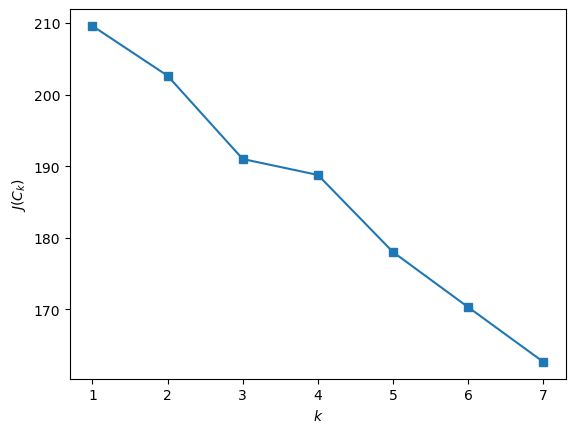

In [76]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(select_features)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

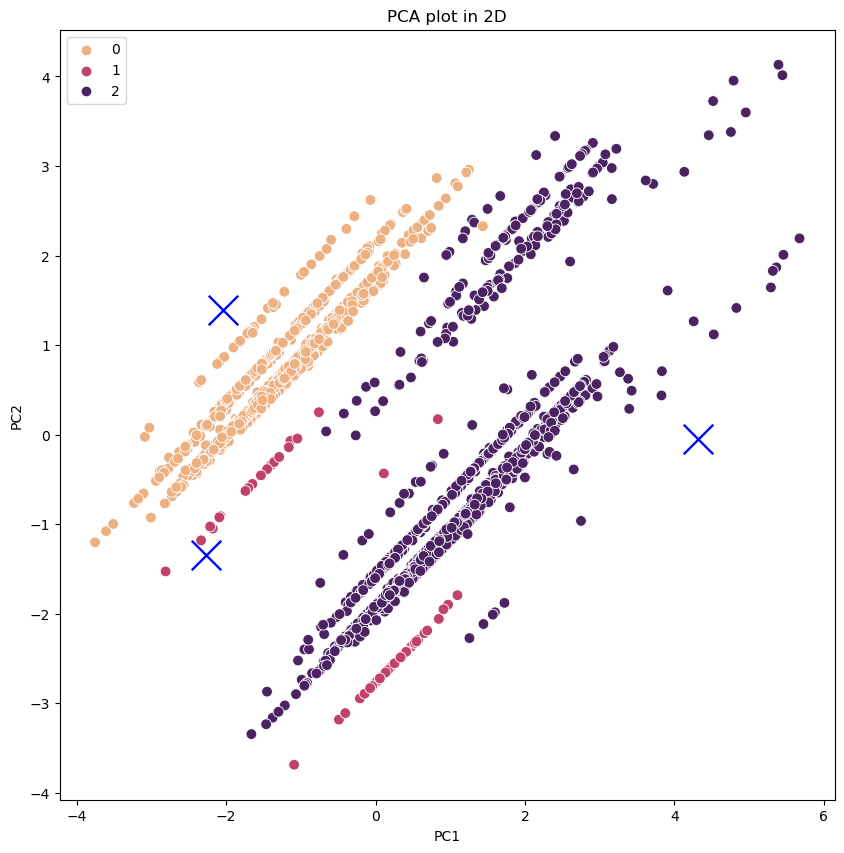

In [77]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_k,
                palette="flare",
                s=60)
sns.scatterplot(x = centroids_pca[:,0],
                y =  centroids_pca[:,1],
                marker="x",
                s=450,
                color = 'blue')
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [78]:
df_cluster = select_features.copy()
df_cluster['K-Means'] = pred_k

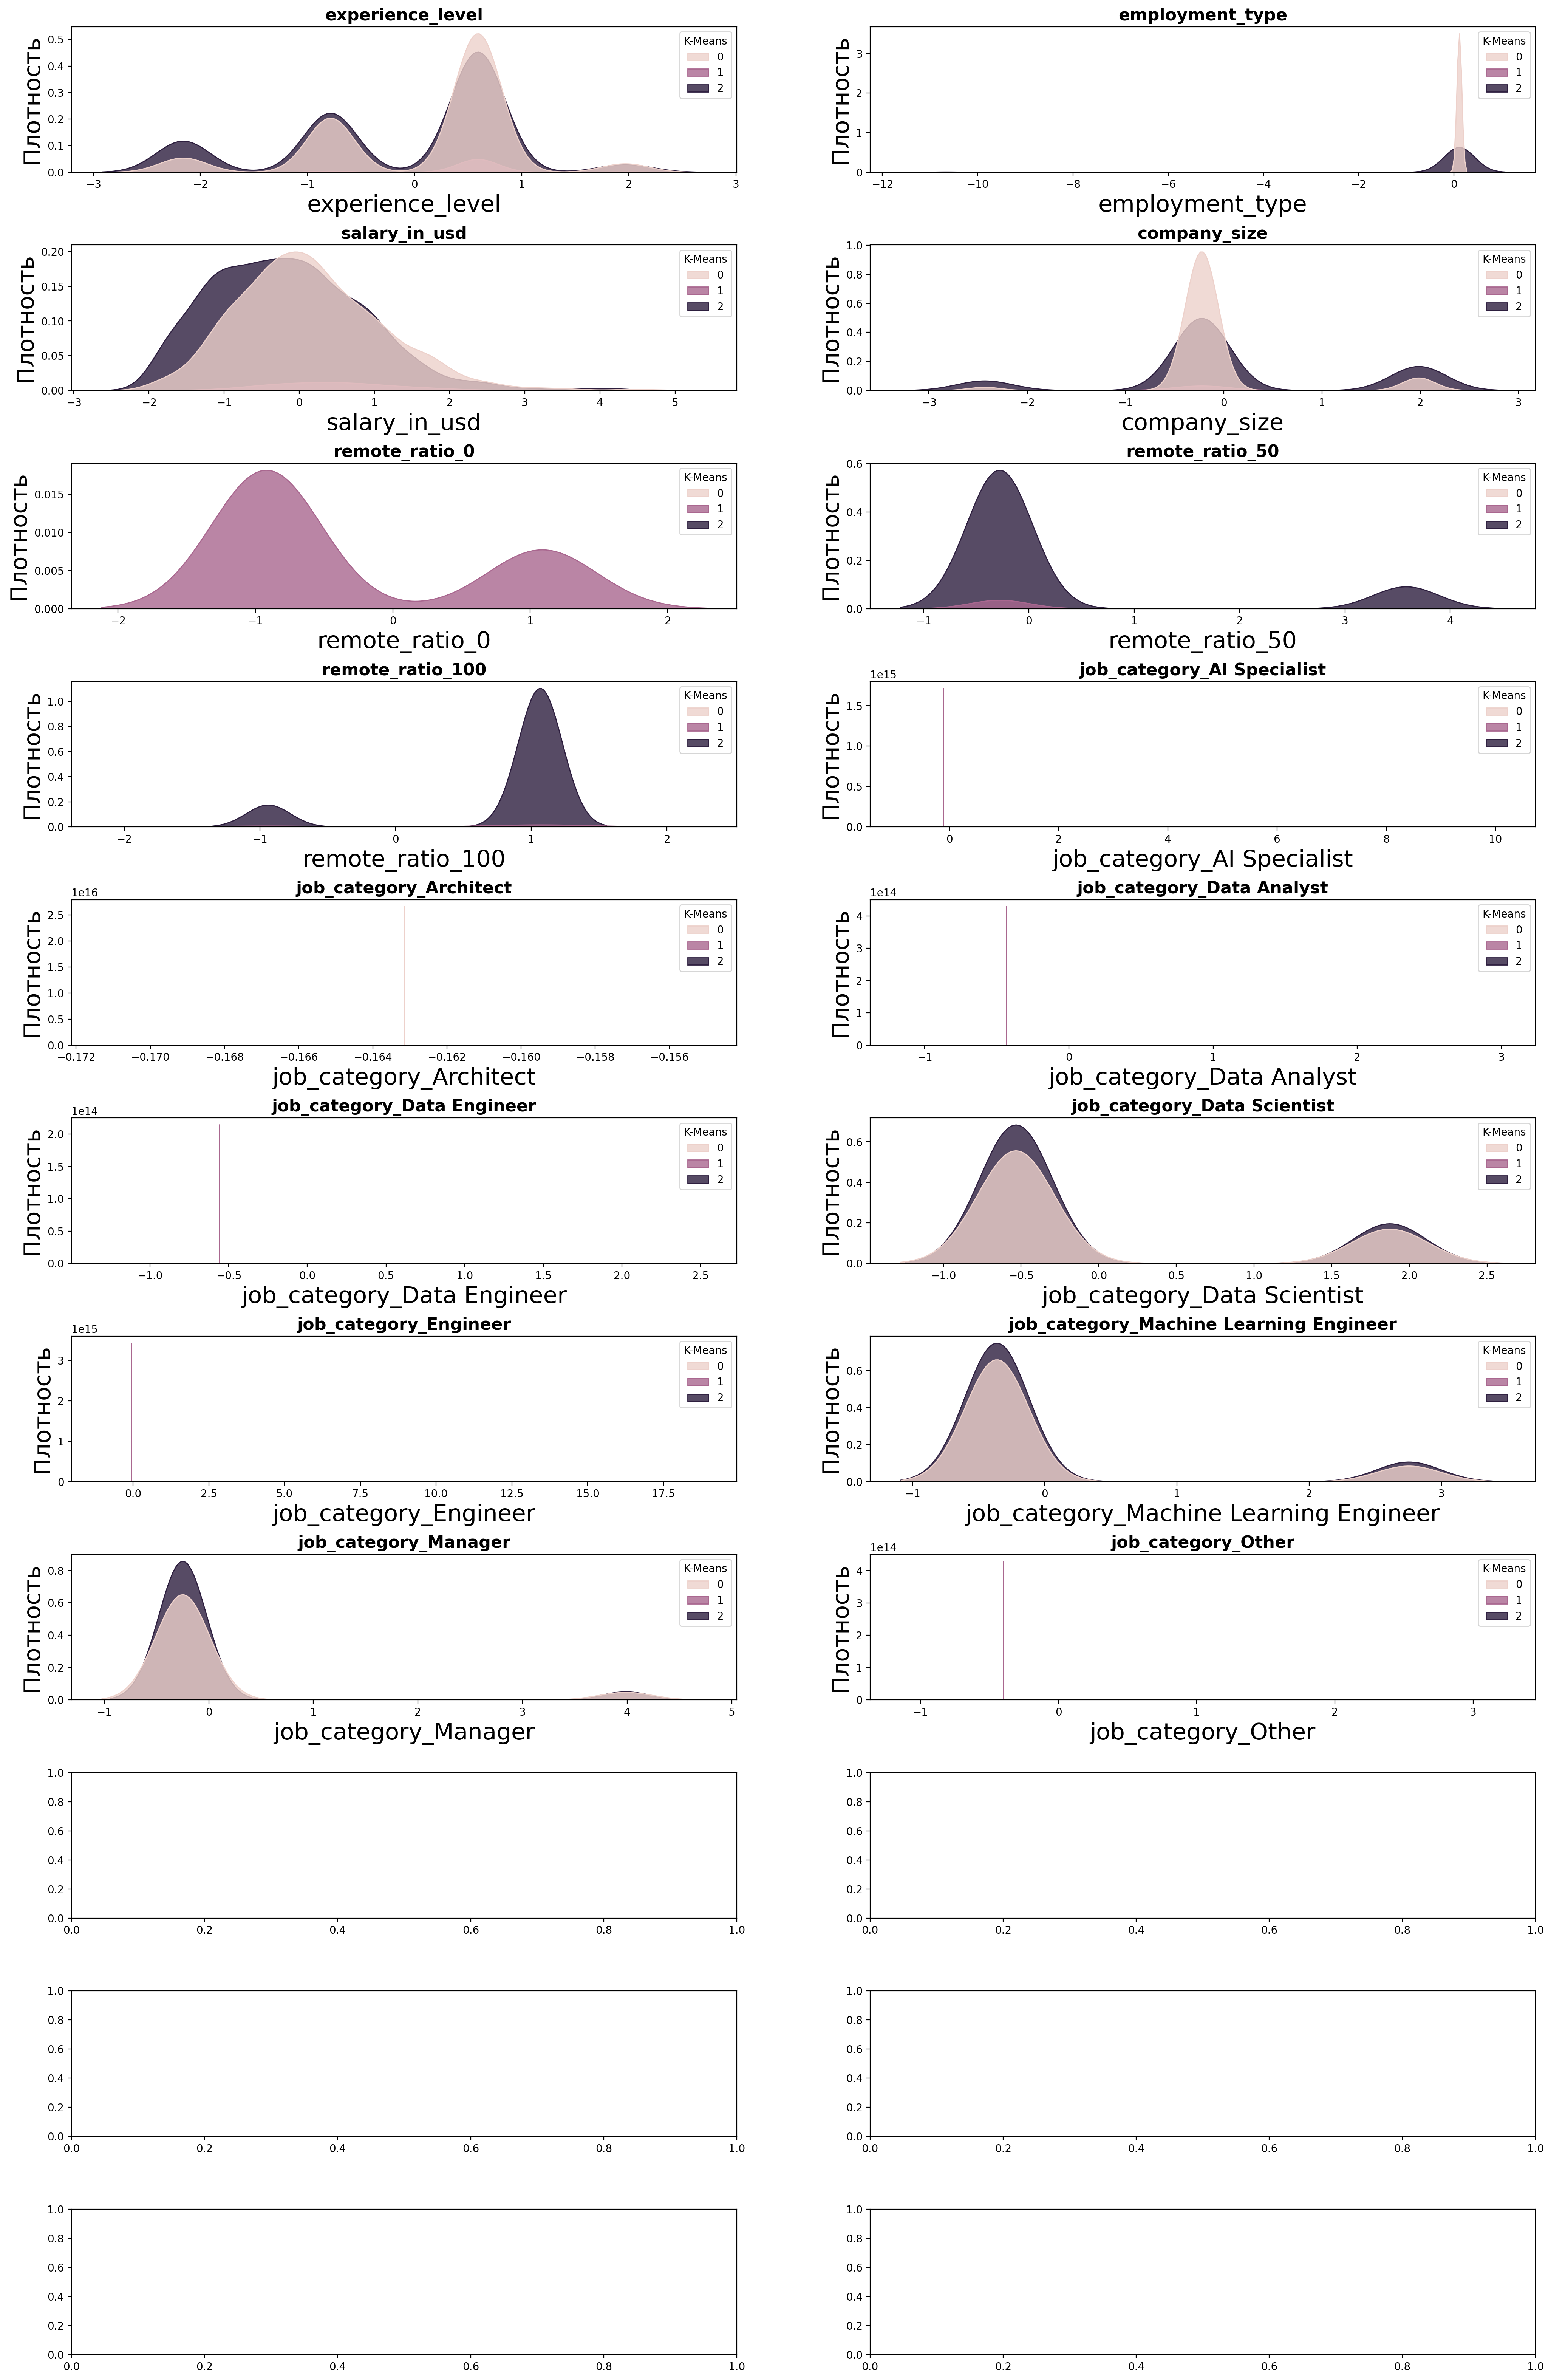

In [80]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(11,2, figsize = (25,40), dpi=200)

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = select_features.columns[:-1]

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df_cluster,
                x = column,
                fill = True,
                alpha = 0.8,
                hue = 'K-Means',
                ax = ax)

    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 22)
    ax.set_ylabel('Плотность', fontsize = 22)

clustering_sp = SpectralClustering(3).fit(select_features)
pred_sp = clustering_sp.labels_

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_sp,
                palette="flare",
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');